In [1]:
setwd('/fs/cbcb-lab/rob/students/noor/Uncertainity/treeTerminusScripts')
dir <- "environment/brain_sim_nodtu_lowfc/mode=gc_bias/post_type=gibbs_nrep=100_tf=100/comp_trees"
term_dir <- "/fs/cbcb-lab/rob/students/noor/Uncertainity/brain_sim_nodtu_lowfc/mode=gc_bias/post_type=gibbs_nrep=100_tf=100/terminus/"
suppressPackageStartupMessages(source("tree_helper_function.R"))
suppressPackageStartupMessages(source("old_terminus_helper.R"))
suppressPackageStartupMessages(library(latex2exp))
suppressPackageStartupMessages(library(beaveR))
load(file.path(dir, "treeCons.RData"))
load(file.path(dir, "yAggConsNS.RData"))
load(file.path(dir, "treeCor.RData"))
load(file.path(dir, "yAggCorNS.RData"))
load(file.path(dir, "treeCons0.RData"))
load(file.path(dir, "yAggConsNS0.RData"))
load(file.path(dir, "treeMeanInf0.RData"))
load(file.path(dir, "yAggMeanInfNS0.RData"))
load(file.path(dir, "treeThr.RData"))
load(file.path(dir, "yAggThrNS.RData"))
load(file.path(dir, "yAggTermThrNS.RData"))
suppressPackageStartupMessages(source("brain_simulation_nodtu/mode=gc_bias/post_type=gibbs_nrep=100_tf=100/tree_analysis/tree_filter.R"))
suppressPackageStartupMessages(library(ggplot2))

In [15]:
devtools::install_github("NPSDC/beaveR")

Skipping 5 packages not available: S4Vectors, tximeta, TreeSummarizedExperiment, SingleCellExperiment, SummarizedExperiment



✔  checking for file ‘/cbcbhomes/npsingh/.tmp/Rtmp2odyPe/remotes51536c10776e/NPSDC-beaveR-dbc90b0/DESCRIPTION’ (610ms)
─  preparing ‘beaveR’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘beaveR_0.99.0.tar.gz’
   


Warning message in i.p(...):
"installation of package '/cbcbhomes/npsingh/.tmp/Rtmp2odyPe/file51531c1aa9fa/beaveR_0.99.0.tar.gz' had non-zero exit status"


In [3]:
dfTPMLFC <- data.frame(matrix(nrow=0, ncol=3))
colnames(dfTPMLFC) <- c("Type", "Value", "nCuts")

l <- length(treeCons$tip)
trees <- list(treeCons, treeCons0, treeMeanInf0, treeCor, treeThr)
names(trees) <- c("ConsFilt", "Cons", "Mean", "AC", "ConsFiltES")
yAgg <- list(yAggConsNS, yAggConsNS0, yAggMeanInfNS0, yAggCorNS, yAggThrNS, yAggTermThrNS)
names(yAgg) <- c("ConsFilt", "Cons", "Mean", "AC", "ConsFiltES", "Term")

dCutsTPM <- vector(mode = "list", length=7)
names(dCutsTPM) <- c(names(yAgg), "Txps")

cutsTPM <- list()
for(n in names(yAgg)) {
    if(n != "Term") {
        trees[[n]]$node.label <- as.character(length(trees[[n]]$tip) + 1:trees[[n]]$Nnode)
        tse <- TreeSummarizedExperiment(assays = assays(yAgg[[n]]), colData = colData(yAgg[[n]]),
            metadata = metadata(yAgg[[n]]), rowTree = trees[[n]])
        descL <- sapply(Descendants(trees[[n]], seq(l+trees[[n]]$Nnode)), length)
        sLFC <- getTPMLFC(tse, "condition")
        met <- abs(sLFC)*descL
        objS <- solveForOptimalCut(tse, metVec = met, type = 'max')
        dCutsTPM[[n]] <- objS[["cut"]]
        df <- data.frame(Type = n, Value = objS[["optVal"]], 
                         nCuts = length(dCutsTPM[[n]]))
        dfTPMLFC <- rbind(dfTPMLFC, df)
        if(n == "ConsFiltES") {
            df <- data.frame(Type = "Txps", Value = sum(abs(met[1:l])), 
                         nCuts = l)
            dfTPMLFC <- rbind(dfTPMLFC, df)
        }
    }
        
    else {
        groupsClust <- parseClustFile(file.path(term_dir, "old", "1_1", "clusters.txt"), yAggTermThrNS, gsub=F)
        mtxps <- setdiff(seq(l), unlist(groupsClust))
        dCutsTPM[[n]] <- c(mtxps, l+1:length(groupsClust))
        descL <- c(rep(1, length(mtxps)), sapply(groupsClust, length))
        infReps <- assays(yAgg[[n]])[grep("infRep", assayNames(yAgg[[n]]))]
        infReps <- abind::abind(as.list(infReps), along = 3)
        mSf <- 0
        for(j in seq(dim(infReps)[3])) {
                sf <- colSums(infReps[1:l,,j])
                mSf <- mean(sf) + mSf
                infReps[,,j] <- t(t(infReps[,,j])/sf)
        }
        mSf <- mSf/dim(infReps)[3]
        
        lfc <- getLog2FC(infReps, colData(yAgg[[n]])[["condition"]], pc = 5/mSf)
        
        df <- data.frame(Type = n, Value = sum(abs(lfc[dCutsTPM[[n]]])*descL), 
                         nCuts = length(dCutsTPM[[n]]))
        dfTPMLFC <- rbind(dfTPMLFC, df)
    }
}
print(dfTPMLFC)
saveDir <- "environment/brain_sim_nodtu_lowfc/mode=gc_bias/post_type=gibbs_nrep=100_tf=100/comp_trees/"
save(dfTPMLFC, file=file.path(saveDir, "dfTPMLFC.RData"))
save(dCutsTPM, file=file.path(saveDir, "dCutsTPM.RData"))

[1] 33470887
        Type    Value  nCuts
1   ConsFilt 45727.68  83290
2       Cons 47188.20  80650
3       Mean 46875.23  81877
4         AC 39297.17 107314
5 ConsFiltES 31716.64 132667
6       Txps 30120.95 139620
7       Term 29364.05 131347


In [11]:
dfTPMLFC

Type,Value,nCuts
<chr>,<dbl>,<int>
ConsFilt,45727.68,83290
Cons,47188.20,80650
Mean,46875.23,81877
AC,39297.17,107314
ConsFiltES,31716.64,132667
Txps,30120.95,139620
Term,29364.05,131347


In [6]:
saveDir <- "environment/brain_sim_nodtu_lowfc/mode=gc_bias/post_type=gibbs_nrep=100_tf=100/comp_trees/"
load(file=file.path(saveDir, "dCutsTPM.RData"))

In [7]:
l <- length(treeCons$tip)
trees <- list(treeCons, treeCons0, treeMeanInf0, treeCor, treeThr)
names(trees) <- c("ConsFilt", "Cons", "Mean", "AC", "ConsFiltES")
yAgg <- list(yAggConsNS, yAggConsNS0, yAggMeanInfNS0, yAggCorNS, yAggThrNS, yAggTermThrNS)
names(yAgg) <- c("ConsFilt", "Cons", "Mean", "AC", "ConsFiltES", "Term")


dfTPMLFCDist <- data.frame(matrix(nrow=0, ncol=2))
colnames(dfTPMLFCDist) <- c("Value", "Type")
for(i in seq_along(trees)) {
    trees[[i]]$node.label <- as.character(length(trees[[i]]$tip) + 1:trees[[i]]$Nnode)
    tse <- TreeSummarizedExperiment(assays = assays(yAgg[[i]]), colData = colData(yAgg[[i]]),
            metadata = metadata(yAgg[[i]]), rowTree = trees[[i]])
    descL <- sapply(Descendants(trees[[i]], seq(l+trees[[i]]$Nnode)), length)
    sLFC <- getTPMLFC(tse, "condition")
    optVal <- abs(sLFC)*descL
    dfTPMLFCDist <- rbind(dfTPMLFCDist, data.frame(Value = optVal[dCutsTPM[[i]]], Type = names(trees)[i]))
}

In [8]:
term_dir <- "/fs/cbcb-lab/rob/students/noor/Uncertainity/brain_sim_nodtu_lowfc/mode=gc_bias/post_type=gibbs_nrep=100_tf=100/terminus/"
groupsClust <- parseClustFile(file.path(term_dir, "old", "1_1", "clusters.txt"), yAggTermThrNS, gsub=F)
mtxps <- setdiff(seq(l), unlist(groupsClust))
mInds <- seq(l + length(groupsClust))
descL <- c(rep(1, length(mtxps)), sapply(groupsClust, length))
n <- "Term"
infReps <- assays(yAgg[[n]])[grep("infRep", assayNames(yAgg[[n]]))]
infReps <- abind::abind(as.list(infReps), along = 3)
mSf <- 0
for(j in seq(dim(infReps)[3])) {
        sf <- colSums(infReps[1:l,,j])
        mSf <- mean(sf) + mSf
        infReps[,,j] <- t(t(infReps[,,j])/sf)
}
mSf <- mSf/dim(infReps)[3]

tpmLFC <- getLog2FC(infReps, colData(yAgg[[n]])[["condition"]], pc = 5/mSf)
dfTPMLFCDist <- rbind(dfTPMLFCDist, data.frame(Value = abs(tpmLFC[dCutsTPM[[n]]])*descL, Type = n))
dfTPMLFCDist <- rbind(dfTPMLFCDist, data.frame(Value = abs(tpmLFC[1:l]), Type = "Txps"))
save(dfTPMLFCDist, file = file.path(saveDir, "dfLLTPM.RData"))

Warning message:
"Width not defined
ℹ Set with `position_dodge(width = ...)`"


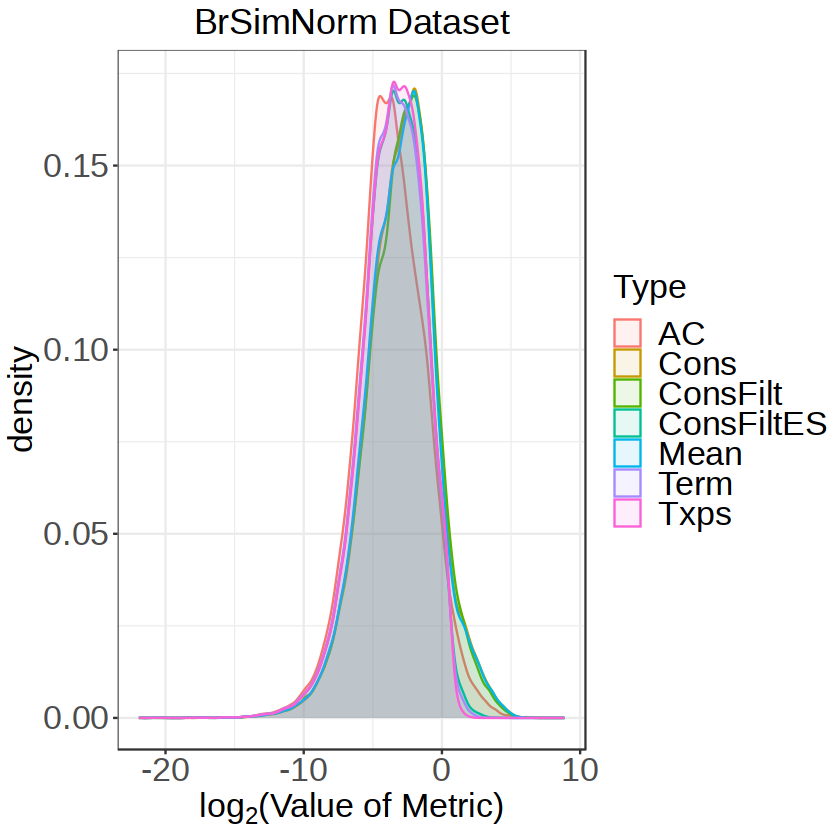

In [9]:
size <- 20
ggplot(dfTPMLFCDist, aes(x=log2(Value), fill = Type, colour = Type)) + 
    geom_density(position = "dodge", alpha=0.1) +
    theme_bw() +
    labs(fill="Type", color="Type") +
    xlab(TeX("$log_{2}$(Value of Metric)")) +
    ggtitle("BrSimNorm Dataset") +
    theme(axis.title = element_text(size = size),
    plot.title = element_text(size = size + 1, hjust=0.5),
    axis.text = element_text(size = size),
    legend.text = element_text(size = size),
    legend.title = element_text(size = size))

In [54]:
dfScaledLFC <- data.frame(matrix(nrow=0, ncol=3))
colnames(dfScaledLFC) <- c("Type", "Value", "nCuts")

l <- length(treeCons$tip)
trees <- list(treeCons, treeCons0, treeMeanInf0, treeCor, treeThr)
names(trees) <- c("ConsInd", "Cons", "Mean", "AC", "ConsRedInd")
yAgg <- list(yAggConsNS, yAggConsNS0, yAggMeanInfNS0, yAggCorNS, yAggThrNS, yAggTermThrNS)
names(yAgg) <- c("ConsInd", "Cons", "Mean", "AC", "ConsRedInd", "Term")

dCutsSLFC <- vector(mode = "list", length=7)
names(dCutsSLFC) <- c(names(yAgg), "Txps")
for(i in seq_along(yAgg)) {
    
    if(i <= 5) {
        globArr <- rep(-100, l+trees[[i]]$Nnode)
        descL <- sapply(Descendants(trees[[i]], seq(l+trees[[i]]$Nnode)), length)
    }
        
    else {
        groupsClust <- parseClustFile(file.path(term_dir, "old", "1_1", "clusters.txt"), yAggTermThrNS, gsub=F)
        mtxps <- setdiff(seq(l), unlist(groupsClust))
        dCutsSLFC[[i]] <- c(mtxps, l+1:length(groupsClust))
        descL <- c(rep(1, length(mtxps)), sapply(groupsClust, length))
    }
        
    infReps <- assays(yAgg[[i]])[grep("infRep", assayNames(yAgg[[i]]))]
    infReps <- abind::abind(as.list(infReps), along = 3)
    mSf <- 0
    for(j in seq(dim(infReps)[3])) {
            sf <- colSums(infReps[1:l,,j])
            mSf <- mean(sf) + mSf
            infReps[,,j] <- t(t(infReps[,,j])/sf)
    }
    mSf <- mSf/dim(infReps)[3]
    print(mSf)
    lfc <- getLog2FC(infReps, colData(yAgg[[i]])[["condition"]], pc = 5/mSf)
    obj <- abs(lfc)/mcols(yAgg[[i]])[["meanInfRV"]]
    if (i==6)         
        val <- sum(obj[dCutsSLFC[[i]]]*descL)

    else {
            val <- findMaxSum(trees[[i]], obj, l+1, descL)
            gc()
            dCutsSLFC[[i]] <- findCuts(trees[[i]], globArr, obj, l+1, descL)
            gc()
    }
    
    dfScaledLFC <- rbind(dfScaledLFC, data.frame(Type = names(yAgg)[i], Value = val,
           nCuts = length(dCutsSLFC[[i]])))

}
i <- 7
dCutsSLFC[[i]] <- 1:l
val <- sum(obj[dCutsSLFC[[i]]])
dfScaledLFC <- rbind(dfScaledLFC, data.frame(Type = "Txp", Value = val,
           nCuts = length(dCutsSLFC[[i]])))
print(dfScaledLFC)
save(dfScaledLFC, file=file.path(dir, "dfScaledLFC.RData"))
save(dCutsSLFC, file=file.path(dir, "dCutsSLFC.RData"))

[1] 33470887
[1] 33470887
[1] 33470887
[1] 33470887
[1] 33470887
[1] 33470887
        Type    Value  nCuts
1    ConsInd 673541.0  41488
2       Cons 758171.6  32877
3       Mean 765669.3  33100
4         AC 500598.9  80983
5 ConsRedInd 184059.1 122809
6       Term 150875.3 131347
7        Txp 135320.2 139620


In [3]:
load(file.path(dir, "dfInf.RData"))
load(file.path(dir, "dCutsDInf.RData"))
load(file.path(dir, "dCutsSLFC.RData"))

In [14]:
l <- length(treeCons$tip)
trees <- list(treeCons, treeCons0, treeMeanInf0, treeCor, treeThr)
names(trees) <- c("ConsFilt", "Cons", "Mean", "AC", "ConsFiltES")
yAgg <- list(yAggConsNS, yAggConsNS0, yAggMeanInfNS0, yAggCorNS, yAggThrNS)
names(yAgg) <- c("ConsFilt", "Cons", "Mean", "AC", "ConsFiltES")
gammas <- c(0.1,0.5,1,5,10)
objsLFC <- vector(mode="list", length(yAgg))
names(objsLFC) <- names(yAgg)
objsDepth <- vector(mode="list", length(yAgg))
names(objsDepth) <- names(yAgg)
for(i in seq_along(yAgg)) {
    descL <- sapply(Descendants(trees[[i]],seq(l+trees[[i]]$Nnode)),length)
    objsDepth[[i]] <- (mcols(yAgg[[i]])[["meanInfRV"]] + 0.1*node.depth(trees[[i]],2))*descL
    infReps <- assays(yAgg[[i]])[grep("infRep", assayNames(yAgg[[i]]))]
    infReps <- abind::abind(as.list(infReps), along = 3)
    mSf <- 0
    for(j in seq(dim(infReps)[3])) {
            sf <- colSums(infReps[1:l,,j])
            mSf <- mean(sf) + mSf
            infReps[,,j] <- t(t(infReps[,,j])/sf)
    }
    mSf <- mSf/dim(infReps)[3]
    print(mSf)
    lfc <- getLog2FC(infReps, colData(yAgg[[i]])[["condition"]], pc = 5/mSf)
    objsLFC[[i]] <- descL*abs(lfc)/mcols(yAgg[[i]])[["meanInfRV"]]
}

[1] 33470887
[1] 33470887
[1] 33470887
[1] 33470887
[1] 33470887


In [15]:
suppressPackageStartupMessages(source("old_terminus_helper.R"))
i <- 6
infReps <- assays(yAggTermThrNS)[grep("infRep", assayNames(yAggTermThrNS))]
infReps <- abind::abind(as.list(infReps), along = 3)
term_dir <- "/fs/cbcb-lab/rob/students/noor/Uncertainity/brain_sim_nodtu_lowfc/mode=gc_bias/post_type=gibbs_nrep=100_tf=100/terminus/"
groupsClust <- parseClustFile(file.path(term_dir, "old", "1_1", "clusters.txt"), yAggTermThrNS, gsub=F)
mtxps <- setdiff(seq(l), unlist(groupsClust))

mSf <- 0
for(j in seq(dim(infReps)[3])) {
            sf <- colSums(infReps[1:l,,j])
            mSf <- mean(sf) + mSf
            infReps[,,j] <- t(t(infReps[,,j])/sf)
    }
mSf <- mSf/dim(infReps)[3]
descL <- c(rep(1, l), sapply(groupsClust, length))


lfc <- getLog2FC(infReps, colData(yAggTermThrNS)[["condition"]], pc = 5/mSf)
objsLFC[[i]] <- descL*abs(lfc)/mcols(yAggTermThrNS)[["meanInfRV"]]
names(objsLFC)[i] <- "Term"

In [8]:
length(descL)
length(lfc)

[1] 145077

[1] 145077

#### Depth

In [16]:
for(i in seq(trees)){
    print(names(trees)[i])
    print(table(node.depth(trees[[i]],2)[dCutsDInf[[1]][[i]]])/length(dCutsDInf[[1]][[i]]))
}

[1] "ConsFilt"

           1            2            3            4            5            6 
8.114480e-01 5.770023e-02 3.933060e-02 3.103582e-02 2.266838e-02 1.485796e-02 
           7            8            9           10           11           12 
9.445158e-03 5.921387e-03 3.124167e-03 2.106997e-03 8.839699e-04 6.054588e-04 
          13           14           15           16           17           18 
3.148386e-04 2.421835e-04 1.210918e-04 3.632753e-05 7.265506e-05 2.421835e-05 
          19           20           22 
1.210918e-05 3.632753e-05 1.210918e-05 
[1] "Cons"

           1            2            3            4            5            6 
8.276052e-01 5.076182e-02 3.524471e-02 2.820475e-02 2.077181e-02 1.401255e-02 
           7            8            9           10           11           12 
9.150826e-03 5.928388e-03 3.435770e-03 1.987357e-03 1.190169e-03 5.614004e-04 
          13           14           15           16           17           18 
5.052603e-04 2.357881e-

In [9]:
names(dCutsDInf[[1]])
names(dCutsSLFC)
names(trees)

[1] "ConsInd"    "Cons"       "Mean"       "AC"         "ConsRedInd"
[6] "Txps"

[1] "ConsInd"    "Cons"       "Mean"       "AC"         "ConsRedInd"
[6] "Term"       "Txps"

[1] "ConsInd"    "Cons"       "Mean"       "AC"         "ConsRedInd"

In [19]:
i <- 1
dfDepth <- data.frame(depthObj = objsDepth[[i]][dCutsDInf[[1]][[i]]], type=names(objsDepth)[i])
for(i in seq(2,5)) {
    dfDepth <- rbind(dfDepth, data.frame(depthObj = objsDepth[[i]][dCutsDInf[[1]][[i]]], type=names(objsDepth)[i]))
}
dfDepth <- rbind(dfDepth, data.frame(depthObj = objsDepth[[i]][1:l], type="Txps"))
size <- 20
pBr <- ggplot(dfDepth, aes(x=depthObj, fill = type, colour = type)) + 
    geom_density(position = "dodge", alpha=0.1) +
    theme_bw() +
    scale_x_continuous(trans="log2") +
    labs(fill="Type", color="Type") +
    xlab("Value of Metric") +
    theme(axis.title = element_text(size = size),
    plot.title = element_text(size = size + 1, hjust=0.5),
    axis.text = element_text(size = size),
    legend.text = element_text(size = size),
    legend.title = element_text(size = size))

Warning message:
"Width not defined. Set with `position_dodge(width = ?)`"


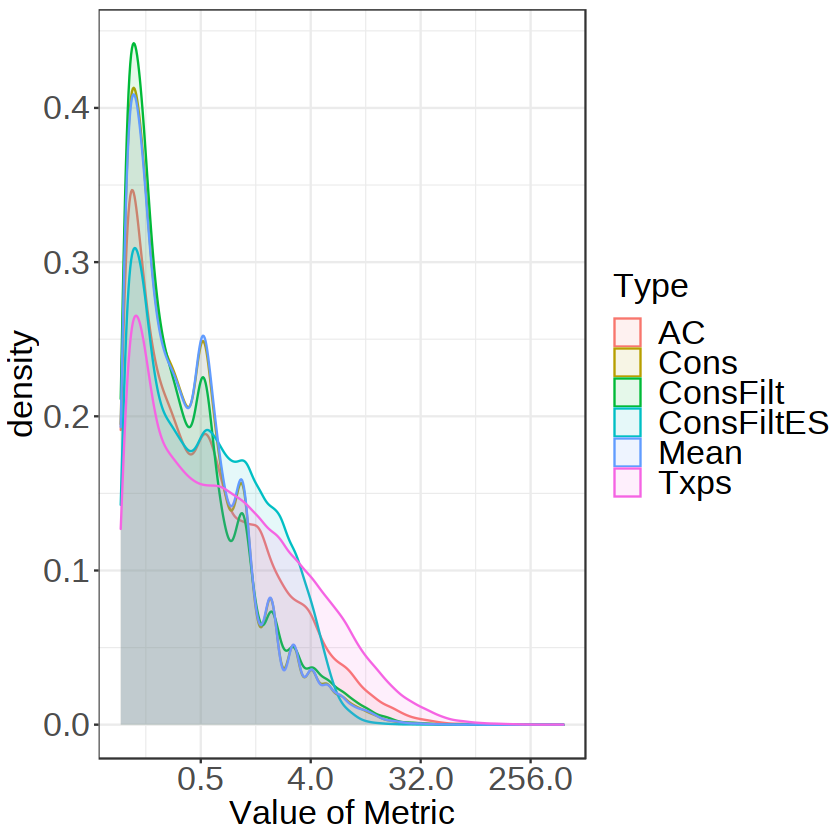

In [21]:
pBr

#### LFC

[1] "ConsFilt"

           1            2            3            4            5            6 
6.160336e-01 8.462688e-02 6.102970e-02 5.411203e-02 4.562765e-02 3.943309e-02 
           7            8            9           10           11           12 
2.771886e-02 2.150019e-02 1.576359e-02 1.050906e-02 7.905901e-03 4.651948e-03 
          13           14           15           16           17           18 
3.470883e-03 2.579059e-03 1.349788e-03 1.084651e-03 9.400309e-04 3.856537e-04 
          19           20           21           22           23           24 
4.338604e-04 3.133436e-04 1.205168e-04 1.205168e-04 9.641342e-05 7.231007e-05 
          25           27           31 
4.820671e-05 2.410336e-05 4.820671e-05 
[1] "Cons"

           1            2            3            4            5            6 
0.5106913648 0.0923746084 0.0631748639 0.0503087265 0.0454725188 0.0367125954 
           7            8            9           10           11           12 
0.0329409618 0.02688809

Warning message:
"Width not defined. Set with `position_dodge(width = ?)`"


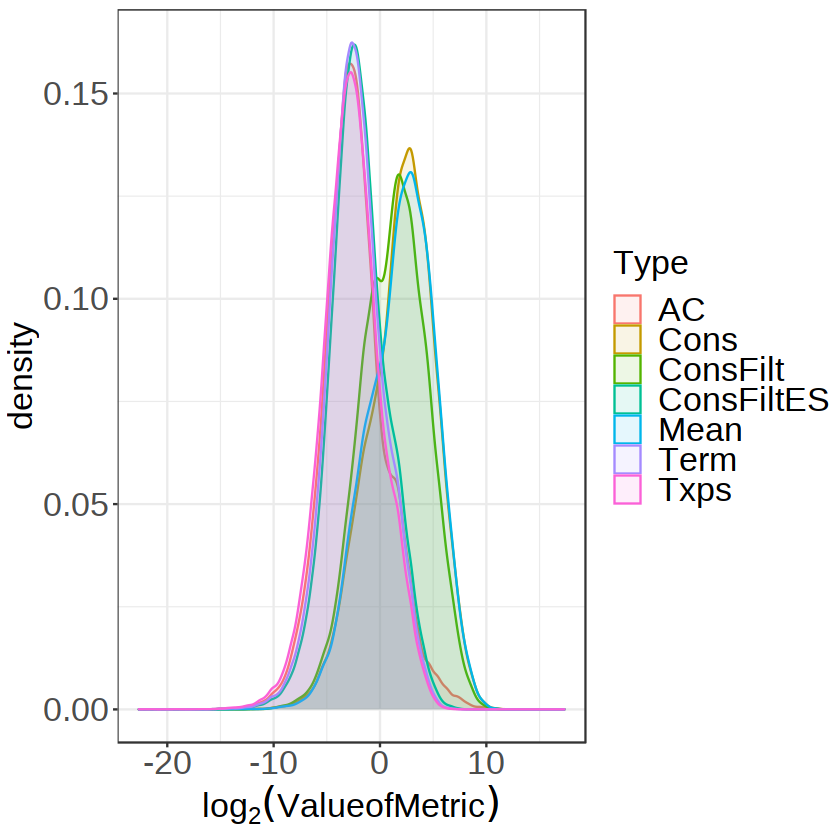

In [25]:
for(i in seq(trees)){
    print(names(trees)[i])
    print(table(node.depth(trees[[i]],2)[dCutsSLFC[[i]]])/length(dCutsSLFC[[i]]))
}
i <- 1
dfLFC <- data.frame(LFC = objsLFC[[i]][dCutsSLFC[[i]]], type=names(objsLFC)[i])
for(i in seq(2,6)) {
    dfLFC <- rbind(dfLFC, data.frame(LFC = objsLFC[[i]][dCutsSLFC[[i]]], type=names(objsLFC)[i]))
}
i <- 7
dfLFC <- rbind(dfLFC, data.frame(LFC = objsLFC[[i-1]][1:l], type="Txps"))
pBr <- ggplot(dfLFC, aes(x=log2(LFC), fill = type, colour = type)) + 
    geom_density(position = "dodge", alpha=0.1) +
    labs(fill="Type", color="Type") +
    xlab(TeX("$log_{2}(Value of Metric)$")) +
    theme_bw() +
    theme(axis.title = element_text(size = size),
    plot.title = element_text(size = size + 1, hjust=0.5),
    axis.text = element_text(size = size),
    legend.text = element_text(size = size),
    legend.title = element_text(size = size))
pBr

In [27]:
save(dfDepth, file=file.path(dir, "dfDe.RData"))
save(dfLFC, file=file.path(dir, "dfLL.RData"))